## MNIST Image Classification with an RNN Model

### Build the dataset and dataloader

In [1]:
import torch
import torchvision
from torchvision import transforms

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Visualize samples from the dataset

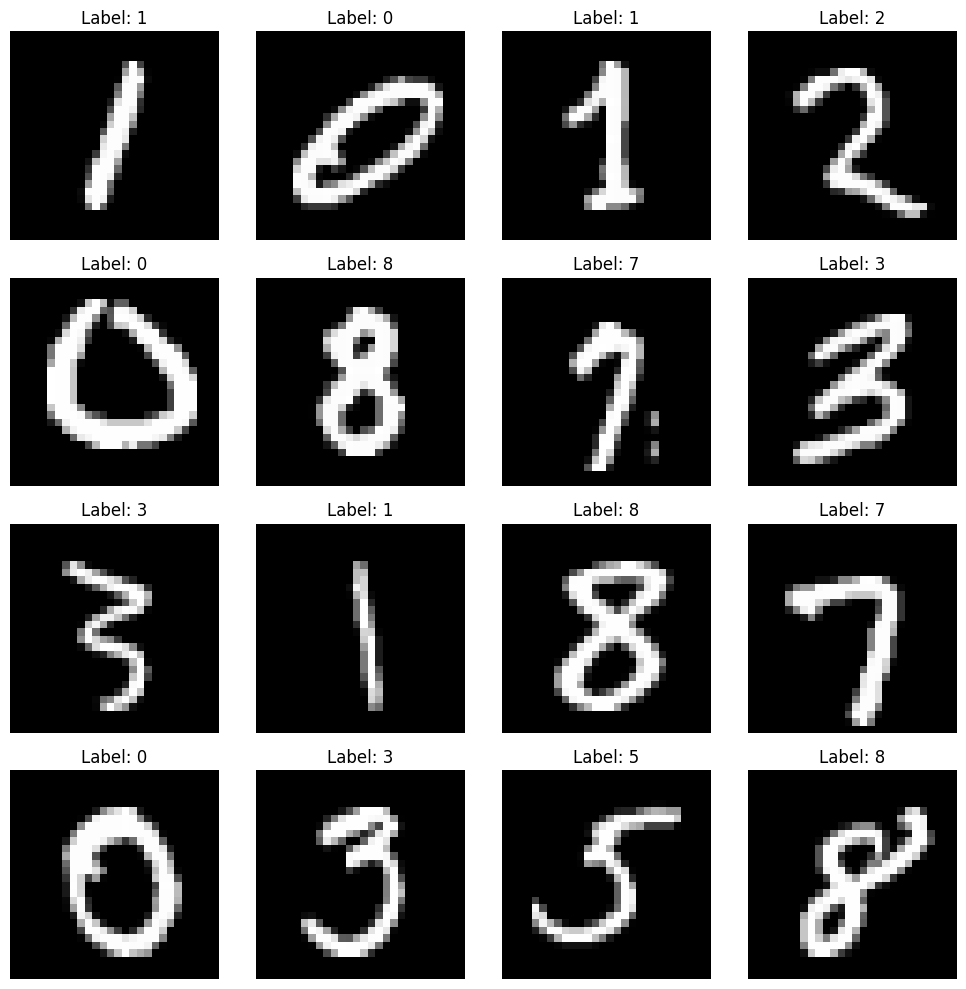

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Get 16 random indices
indices = np.random.choice(len(train_dataset), size=16, replace=False)

# Get the corresponding images and labels
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the subplots and display the images with labels
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


### Build the RNN Model

In [3]:
import torch
import torch.nn as nn

# Build an RNN model to classsify MNIST images
class RNN(nn.Module):
    def __init__(self, input_size=28, hidden_size=256, num_layers=1, num_classes=10):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # input is a "sequence" of 28 features w/ length 28
        x = x.squeeze(1)
        y, _ = self.rnn(x) #, h0)
        # retrieve the last element of the sequence
        y = self.fc(y[:, -1, :])
        return y


x = torch.randn(64, 1, 28, 28)
model = RNN()
print(model)
print(model(x).shape)

# print the number of parameters
num_params = sum(p.numel() for p in model.parameters())
# Use comma to print the number in a more readable format
print(f"Number of parameters: {num_params:,}")

RNN(
  (rnn): RNN(28, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([64, 10])
Number of parameters: 75,786


In [4]:
# Accessing the weight tensors
print(model.rnn.weight_ih_l0.shape)  # (256, 28) -> input-to-hidden weights
print(model.rnn.weight_hh_l0.shape)  # (256, 256) -> hidden-to-hidden weights
print(model.rnn.bias_ih_l0.shape)    # (256,) -> bias for input-to-hidden
print(model.rnn.bias_hh_l0.shape)    # (256,) -> bias for hidden-to-hidden

# Output layer
print(model.fc.weight.shape)         # (10, 256) -> final FC layer weights
print(model.fc.bias.shape)        


torch.Size([256, 28])
torch.Size([256, 256])
torch.Size([256])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


### Define the loss function and optimizer

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [6]:
from tqdm import tqdm

num_epochs = 10

model.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")


 10%|█         | 1/10 [00:06<00:58,  6.49s/it]

Epoch: 1, Loss: 0.6430


 20%|██        | 2/10 [00:12<00:51,  6.44s/it]

Epoch: 2, Loss: 0.2639


 30%|███       | 3/10 [00:19<00:45,  6.44s/it]

Epoch: 3, Loss: 0.2014


 40%|████      | 4/10 [00:25<00:38,  6.44s/it]

Epoch: 4, Loss: 0.1724


 50%|█████     | 5/10 [00:32<00:32,  6.46s/it]

Epoch: 5, Loss: 0.1488


 60%|██████    | 6/10 [00:38<00:25,  6.46s/it]

Epoch: 6, Loss: 0.1495


 70%|███████   | 7/10 [00:45<00:19,  6.46s/it]

Epoch: 7, Loss: 0.1435


 80%|████████  | 8/10 [00:51<00:12,  6.49s/it]

Epoch: 8, Loss: 0.1327


 90%|█████████ | 9/10 [00:58<00:06,  6.53s/it]

Epoch: 9, Loss: 0.1312


100%|██████████| 10/10 [01:05<00:00,  6.53s/it]

Epoch: 10, Loss: 0.1215


In [7]:
import numpy as np

# After training the model
model_params = {}
for name, param in model.named_parameters():
    model_params[name] = param.data.cpu().numpy()

# Save the parameters to a file
np.save('rnn_params.npy', model_params)

print("Model parameters saved to rnn_params.npy")

Model parameters saved to rnn_params.npy


In [8]:
class NumpyRNN:
    def __init__(self, input_size, hidden_size, num_classes):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        # Initialize weights and biases
        self.U = np.random.randn(hidden_size, input_size) * 0.01
        self.W = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((hidden_size, 1))
        self.V = np.random.randn(num_classes, hidden_size) * 0.01
        self.c = np.zeros((num_classes, 1))

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        batch_size, sequence_length, input_size = x.shape
    
        # Initialize hidden state (batch_size, hidden_size)
        h = np.zeros((batch_size, self.hidden_size))
    
        for t in range(sequence_length):
            xt = x[:, t, :]
            # Apply input-to-hidden transformation and bias
            input_term = np.dot(xt, self.U.T) + self.b1.T
            # Apply hidden-to-hidden transformation and bias
            hidden_term = np.dot(h, self.W.T) + self.b2.T
            # Update hidden state
            h = np.tanh(input_term + hidden_term)
    
        # Output computation after processing all time steps
        y = np.dot(h, self.V.T) + self.c.T
    
        return y


    def load_parameters(self, params):
        self.U = params['rnn.weight_ih_l0']
        self.W = params['rnn.weight_hh_l0']
        self.b1 = params['rnn.bias_ih_l0'].reshape(-1, 1)
        self.b2 = params['rnn.bias_hh_l0'].reshape(-1, 1)
        self.V = params['fc.weight']
        self.c = params['fc.bias'].reshape(-1, 1)
        
        print(f"self.U = {self.U.shape}")
        print(f"self.W = {self.W.shape}")
        print(f"self.b1 = {self.b1.shape}")
        print(f"self.b2 = {self.b2.shape}")
        print(f"self.V = {self.V.shape}")
        print(f"self.c = {self.c.shape}")

In [9]:
import numpy as np

# Load the saved parameters
loaded_params = np.load('rnn_params.npy', allow_pickle=True).item()

# Create and initialize the numpy RNN
input_size = 28
hidden_size = 256
num_classes = 10
numpy_rnn = NumpyRNN(input_size, hidden_size, num_classes)
numpy_rnn.load_parameters(loaded_params)

print("Numpy RNN created and initialized with loaded parameters")

self.U = (256, 28)
self.W = (256, 256)
self.b1 = (256, 1)
self.b2 = (256, 1)
self.V = (10, 256)
self.c = (10, 1)
Numpy RNN created and initialized with loaded parameters


### Evaluate the model

In [10]:
import numpy as np
from tqdm import tqdm

def test_numpy_rnn(numpy_rnn, test_loader):
    correct = 0
    total = 0

    for images, labels in tqdm(test_loader, desc="Testing"):
        # Convert PyTorch tensors to numpy arrays
        images_np = images.numpy()
        labels_np = labels.numpy()
                
        # Reshape images to (batch_size, sequence_length, input_size)
        batch_size, _, height, width = images_np.shape
        images_np = images_np.reshape(batch_size, height, width)
        
        # Forward pass
        outputs = numpy_rnn.forward(images_np)
        
        # Get predictions
        predicted = np.argmax(outputs, axis=1)
                
        # Update statistics
        total += labels_np.shape[0]
        correct += np.sum(predicted == labels_np)
        
        # print(f"outputs = {outputs}")
        # print(f"predicted = {predicted}")
        # print(f"labels_np = {labels_np}")
                
    accuracy = correct / total
    return accuracy

# Assuming numpy_rnn is your initialized NumpyRNN model
accuracy = test_numpy_rnn(numpy_rnn, test_loader)
print(f"Test Accuracy: {accuracy:.4f}")

Testing: 100%|██████████| 157/157 [00:04<00:00, 38.64it/s]

Test Accuracy: 0.9667


In [11]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # print(f"outputs = {outputs}")
        # print(f"predicted = {predicted}")
        # print(f"labels = {labels}")
        
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9667


### Predict on sample images

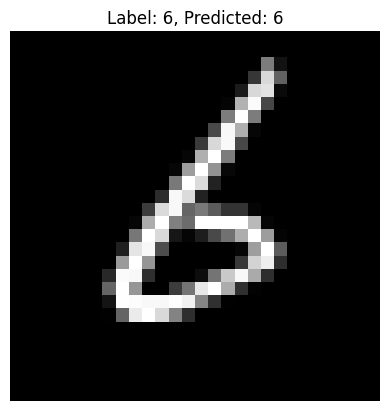

In [12]:
import random

# Set the model to evaluation mode
model.eval()

# Select a random image from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Move the image to the device
image = image.to(device)

# Forward pass to get the predicted label
output = model(image.unsqueeze(0))
_, predicted_label = torch.max(output, 1)

# Convert the image tensor to a numpy array
image_np = image.cpu().numpy()

# Display the image, its label, and the predicted label
plt.imshow(image_np.squeeze(), cmap='gray')
plt.title(f"Label: {label}, Predicted: {predicted_label.item()}")
plt.axis('off')
plt.show()
